# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI method and create high-quality plots of the results.
This tutorial explains the main features in walk-through examples. It covers:

1. Basic usage
2. Plotting
3. Nonlinear conditional independence tests
4. Symbolic time series

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

## 1. Basic usage

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

Consider time series coming from a data generating process

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.7 X^3_{t-1} + \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function ``pp.var_process``.

In [2]:
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names= var_names)


First, we plot the time series. This can be done with the function ``tp.plot_timeseries``

(<Figure size 432x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aeafb0a7950>,
       dtype=object))

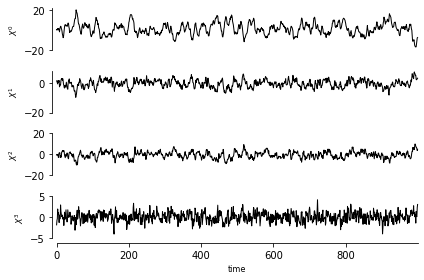

In [3]:
tp.plot_timeseries(dataframe)

It's stationary and doesn't contain missing values (covered in other tutorial). Next, we choose a conditional independence test, here we start with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` method with  ``dataframe``, and ``cond_ind_test``:

In [4]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

In [6]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Running Tigramite PC algorithm
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = None
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

## Variable $X^1$

## Variable $X^2$

## Variable $X^3$

## Resulting condition sets:

    Variable $X^0$ has 7 parent(s):
    [pc_alpha = 0.3]
        ($X^0$ -1): max_pval = 0.00000, min_val = 0.796
        ($X^1$ -1): max_pval = 0.00000, min_val = 0.748
        ($X^3$ -2): max_pval = 0.13715, min_val = 0.048
        ($X^3$ -1): max_pval = 0.19326, min_val = 0.042
        ($X^2$ -1): max_pval = 0.20477, min_val = 0.041
        ($X^3$ -7): max_pval = 0.25822, min_val = 0.036
        ($X^1$ -4): max_pval = 0.26548, min_val = 0.036

    Variable $X^1$ has 4 parent(s):
    [pc_alpha = 0.3]
        ($X^1$ -1): max_pval = 0.00000, min_val = 0.695
        ($X^3$ -1): max_pval = 0.00000, min_val = 0.484
        ($X^3$ -7): max_pval = 0.14660, min_val = 0.046
        ($X^2$ -1): max_pval = 0.22144, min_val = 0

As you can see from the output, PCMCI selected different ``pc_alpha`` for each variable. The result of ``run_pcmci`` is a dictionary containing the matrix of p-values, the matrix of test statistic values (here MCI partial correlations), and optionally its confidence bounds (can be specified upon initializing ``ParCorr``). ``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry ``(i, j, \tau)`` denoting the test for the link $X^i_{t-\tau} \to X^j_t$. The MCI values for $\tau=0$ do not exclude other contemporaneous effects, only past variables are conditioned upon.

In [ ]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. At a chosen significance level the detected parents of each variable can then be printed:

In [8]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val = -0.653
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.566

    Variable $X^1$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.663
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.622

    Variable $X^2$ has 3 link(s):
        ($X^3$ -3): pval = 0.00000 | qval = 0.00000 | val = 0.451
        ($X^1$ -2): pval = 0.00000 | qval = 0.00000 | val = 0.446
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.425

    Variable $X^3$ has 1 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.372


## 2. Plotting

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the boolean ``link_matrix`` which denotes significant links by ``1``. This boolean matrix has to be created from the p-/q-matrix by choosing some ``alpha_level``.

In [9]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.

(<Figure size 432x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2ab67c78cad0>)

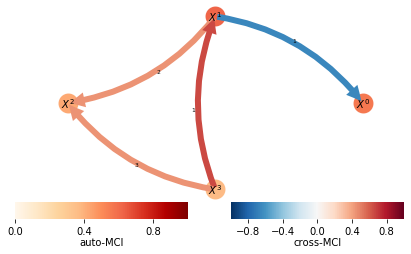

In [10]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    )

# Sketch for SPCAM causal-links (made-up example) 

Consider time series coming from a data generating process

\begin{align*}
I^1_t &= 0.8 I^1_{t-1} - 0.8 I^2_{t-1} + \eta^1_t\\
I^2_t &= 0.5 I^2_{t-2} + 0.5 I^1_{t-1} + \eta^2_t\\
I^3_t &= 0.7 I^3_{t-1} + \eta^3_t\\
O^1_t &= 0.7 I^1_{t-1} - 0.8 I^3_{t-1} + \eta^4_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function ``pp.var_process``.

In [26]:
np.random.seed(42)     # Fix random seed
# Full causal-links
links_coeffs = {0: [((0, -1), 0.8), ((1, -1), -0.8)],
                1: [((0, -1), 0.5), ((1, -2), -0.5)],
                2: [((2, -1), 0.7)],
                3: [((0, -1), 0.7), ((2, -1), -0.8)],
                }

# Output causal-links
# links_coeffs = {0: [],
#                 1: [],
#                 2: [],
#                 3: [((0, -1), 0.7), ((2, -1), -0.8)],
#                 }

T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$I^1$', r'$I^2$', r'$I^3$', r'$O^1$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names= var_names)

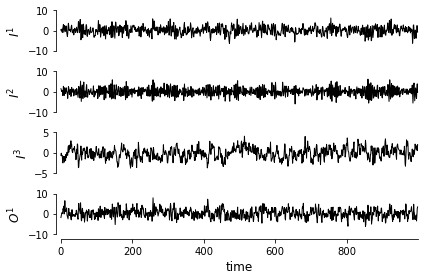

In [27]:
tp.plot_timeseries(dataframe,save_name='./plots_causal_links_example/211103_timeseries_system.png',)

In [28]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

In [29]:
pcmci.verbosity = 1
# results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
links = pcmci.run_pc_stable(tau_max=2)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $I^1$ has 3 parent(s):
        ($I^2$ -1): max_pval = 0.00000, min_val = -0.422
        ($I^1$ -1): max_pval = 0.00000, min_val =  0.295
        ($I^3$ -1): max_pval = 0.04371, min_val = -0.064

    Variable $I^2$ has 4 parent(s):
        ($I^2$ -2): max_pval = 0.00000, min_val = -0.473
        ($I^1$ -1): max_pval = 0.00000, min_val =  0.420
        ($O^1$ -1): max_pval = 0.13383, min_val =  0.048
        ($I^1$ -2): max_pval = 0.16868, min_val =  0.044

    Variable $I^3$ has 2 parent(s):
        ($I^3$ -1): max_pval = 0.00000, min_val =  0.556
        ($O^1$ -1): max_pval = 0.11921, min_val =  0.049

    Variable $O^1$ has 2 parent(s):
        ($I^1$ -1): max_pval = 0.00000, min_val =  0.703
        ($I^3$ -1): max_pval = 0.00000, min_val = -0.549


In [30]:
results = {
    "links": links,
    "p_matrix": pcmci.p_matrix,
    "val_matrix": pcmci.val_matrix,
}

In [31]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

In [32]:
link_matrix = pcmci.return_significant_parents(
    pq_matrix=q_matrix,
    val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

/work/bd0854/b309172/conda_envs/tg38plus/lib/python3.8/site-packages/tigramite-4.2.1.5-py3.8-linux-x86_64.egg/tigramite/pcmci.py:1443: UserWarning: return_significant_parents is DEPRECATED: use return_significant_links() instead and check updated key names.
  warnings.warn("return_significant_parents is DEPRECATED: use "


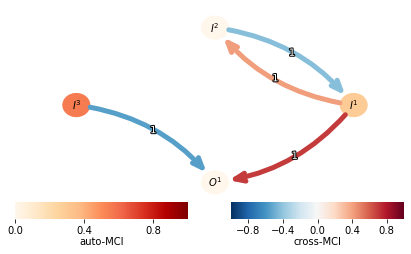

In [33]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    save_name='./plots_causal_links_example/211103_full_causal_links.png',
#     save_name='./plots_causal_links_example/211103_output_causal_links.png',
    )